In [1]:
"""
Weather Data Preprocessing Notebook

This notebook performs data cleaning & feature engineering of weather data data.
"""

'\nWeather Data Preprocessing Notebook\n\nThis notebook performs data cleaning & feature engineering of weather data data.\n'

In [2]:
import os
import sys
from datetime import datetime

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, IntegerType


## Load in Weather Data

In [3]:
# Create spark session
spark = (
    SparkSession.builder.appName("Weather Preprocessing")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "America/New_York")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "16g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/28 00:33:44 WARN Utils: Your hostname, JamesNsPC, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/28 00:33:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/28 00:33:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/28 00:33:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
weather_sdf = spark.read.parquet("../data/landing/weather_data")

In [5]:
# Get columns and datatypes
weather_columns = weather_sdf.columns

for column in weather_columns:
    print(f"{column}: {weather_sdf.schema[column].dataType}")

apparent_temperature: DoubleType()
cloud_cover: LongType()
direct_radiation: DoubleType()
is_day: LongType()
precipitation: DoubleType()
rain: DoubleType()
relative_humidity_2m: LongType()
shortwave_radiation: DoubleType()
snow_depth: DoubleType()
snowfall: DoubleType()
sunshine_duration: DoubleType()
surface_pressure: DoubleType()
temperature_2m: DoubleType()
timestamp: StringType()
weather_code: LongType()
wind_gusts_10m: DoubleType()
wind_speed_10m: DoubleType()
BoroName: StringType()


In [6]:
weather_sdf.show(10)

+--------------------+-----------+----------------+------+-------------+----+--------------------+-------------------+----------+--------+-----------------+----------------+--------------+----------------+------------+--------------+--------------+--------+
|apparent_temperature|cloud_cover|direct_radiation|is_day|precipitation|rain|relative_humidity_2m|shortwave_radiation|snow_depth|snowfall|sunshine_duration|surface_pressure|temperature_2m|       timestamp|weather_code|wind_gusts_10m|wind_speed_10m|BoroName|
+--------------------+-----------+----------------+------+-------------+----+--------------------+-------------------+----------+--------+-----------------+----------------+--------------+----------------+------------+--------------+--------------+--------+
|                24.1|         11|           606.0|     1|          0.0| 0.0|                  50|              803.0|       0.0|     0.0|           3600.0|          1013.6|          26.0|2024-06-13T15:00|           0|        

We must convert timestamp to date/time, doubles to floats (don't need extreme precision), as well as our LongType columns to int values to save space/computation.



In [7]:
# Convert timestamp
weather_sdf = weather_sdf.withColumn("timestamp", F.to_timestamp(F.col("timestamp")))


# Convert cloud_cover, is_day, relative_humidity, weather_code to integer to save space
to_int = ["cloud_cover", "is_day", "relative_humidity_2m", "weather_code"]


# Convert DoubleType columns to FloatType to save space and longs to ints
for field in weather_sdf.schema.names:
    dtype = dict(weather_sdf.dtypes)[field]
    if dtype == "DoubleType":
        weather_sdf = weather_sdf.withColumn(
            field, weather_sdf[field].cast(FloatType())
        )
    elif dtype == "long":
        weather_sdf = weather_sdf.withColumn(
            field, weather_sdf[field].cast(IntegerType)
        )

In [ ]:
weather_columns = weather_sdf.columns
# Print new schema
for column in weather_columns:
    print(f"{column}: {weather_sdf.schema[column].dataType}")

apparent_temperature: DoubleType()
cloud_cover: LongType()
direct_radiation: DoubleType()
is_day: LongType()
precipitation: DoubleType()
rain: DoubleType()
relative_humidity_2m: LongType()
shortwave_radiation: DoubleType()
snow_depth: DoubleType()
snowfall: DoubleType()
sunshine_duration: DoubleType()
surface_pressure: DoubleType()
temperature_2m: DoubleType()
timestamp: TimestampType()
weather_code: LongType()
wind_gusts_10m: DoubleType()
wind_speed_10m: DoubleType()
BoroName: StringType()


In [9]:
weather_sdf.count()

52704

#### Check for nulls

In [10]:
sys.path.append("../functions")
from processing import is_expected, report_null

report_null(weather_sdf, "Weather")


 Results for Weather
0


#### Remove Unrealistic Values

In [ ]:
# From reviewing https://open-meteo.com/en/docs and inspecting other data to see what super unrealistic values would be
expected_ranges = {
    "apparent_temperature": {"min": -80.0, "max": 60.0},  # °C
    "cloud_cover": {"min": 0, "max": 100},  # %
    "direct_radiation": {"min": 0.0, "max": 1500.0},  # W/m²
    "is_day": {"allowed_values": [0, 1]},
    "precipitation": {"min": 0.0, "max": 500.0},  # mm
    "rain": {"min": 0.0, "max": 500.0},
    "relative_humidity_2m": {"min": 0, "max": 100},  # %
    "shortwave_radiation": {"min": 0.0, "max": 1500.0},  # W/m²
    "snow_depth": {"min": 0.0, "max": 2000.0},  # mm
    "snowfall": {"min": 0.0, "max": 500.0},
    "sunshine_duration": {"min": 0.0, "max": 86400.0},  # seconds/day
    "surface_pressure": {"min": 800.0, "max": 1100.0},  # hPa
    "temperature_2m": {"min": -80.0, "max": 60.0},  # °C
    "timestamp": {
        "min": datetime(2024, 1, 1, 0, 0, 0),
        "max": datetime(2024, 12, 31, 23, 59, 59),
    },
    "weather_code": {"min": 0, "max": 100},
    "wind_gusts_10m": {"min": 0.0, "max": 120.0},  # m/s
    "wind_speed_10m": {"min": 0.0, "max": 80.0},
}


In [12]:
results, combined_cond = is_expected(weather_sdf, expected_ranges)

Column 'apparent_temperature': 0 Invalid values found.
Column 'cloud_cover': 0 Invalid values found.
Column 'direct_radiation': 0 Invalid values found.
Column 'is_day': 0 Invalid values found.
Column 'precipitation': 0 Invalid values found.
Column 'rain': 0 Invalid values found.
Column 'relative_humidity_2m': 0 Invalid values found.
Column 'shortwave_radiation': 0 Invalid values found.
Column 'snow_depth': 0 Invalid values found.
Column 'snowfall': 0 Invalid values found.
Column 'sunshine_duration': 0 Invalid values found.
Column 'surface_pressure': 0 Invalid values found.
Column 'temperature_2m': 0 Invalid values found.
Column 'timestamp': 96 Invalid values found.
Column 'weather_code': 0 Invalid values found.
Column 'wind_gusts_10m': 0 Invalid values found.
Column 'wind_speed_10m': 0 Invalid values found.


Most readings are hence believable, check and remove out of range times

In [13]:
weather_sdf.select(F.min("timestamp"), F.max("timestamp")).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|2024-01-01 00:00:00|2024-12-31 23:00:00|
+-------------------+-------------------+



In [ ]:
# Time bounds
min_time = datetime(2024, 1, 1, 0, 0, 0)
max_time = datetime(2024, 12, 31, 23, 59, 59)

# Filter for timestamps outside the range
out_of_range_times = weather_sdf.filter(
    (F.col("timestamp") < F.lit(min_time)) | (F.col("timestamp") > F.lit(max_time))
)

# Show them
out_of_range_times.select("timestamp").show(50, truncate=False)

# Count them
print(f"Out-of-range timestamp count: {out_of_range_times.count()}")


+-------------------+
|timestamp          |
+-------------------+
|2024-12-31 08:00:00|
|2024-12-31 09:00:00|
|2024-12-31 10:00:00|
|2024-12-31 11:00:00|
|2024-12-31 12:00:00|
|2024-12-31 13:00:00|
|2024-12-31 14:00:00|
|2024-12-31 15:00:00|
|2024-12-31 16:00:00|
|2024-12-31 17:00:00|
|2024-12-31 18:00:00|
|2024-12-31 19:00:00|
|2024-12-31 20:00:00|
|2024-12-31 21:00:00|
|2024-12-31 22:00:00|
|2024-12-31 23:00:00|
|2024-12-31 08:00:00|
|2024-12-31 09:00:00|
|2024-12-31 10:00:00|
|2024-12-31 11:00:00|
|2024-12-31 12:00:00|
|2024-12-31 13:00:00|
|2024-12-31 14:00:00|
|2024-12-31 15:00:00|
|2024-12-31 16:00:00|
|2024-12-31 17:00:00|
|2024-12-31 18:00:00|
|2024-12-31 19:00:00|
|2024-12-31 20:00:00|
|2024-12-31 21:00:00|
|2024-12-31 22:00:00|
|2024-12-31 23:00:00|
|2024-12-31 08:00:00|
|2024-12-31 09:00:00|
|2024-12-31 10:00:00|
|2024-12-31 11:00:00|
|2024-12-31 12:00:00|
|2024-12-31 13:00:00|
|2024-12-31 14:00:00|
|2024-12-31 15:00:00|
|2024-12-31 16:00:00|
|2024-12-31 17:00:00|
|2024-12-3

These are all fine, just a Spark issue so we leave them

#### Remove duplicates

In [ ]:
weather_sdf = weather_sdf.dropDuplicates()
weather_sdf.count()

52704

No duplicates, data is very clean. \
Since data is sensor data we will keep all data points, including anything that could be deemed an outlier.

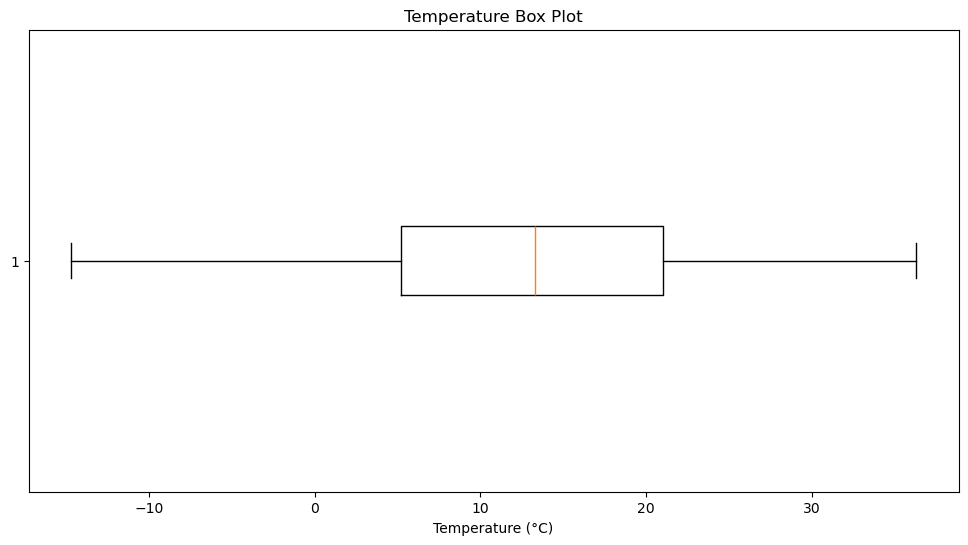

In [ ]:
# Temperature box plot
import matplotlib.pyplot as plt
# Convert Spark DataFrame to Pandas for plotting
temp_pd = weather_sdf.select("temperature_2m").toPandas()

plt.figure(figsize=(12, 6))
plt.boxplot(temp_pd['temperature_2m'], vert=False)
plt.title('Temperature Box Plot')
plt.xlabel('Temperature (°C)')
plt.show()

Confirms data is likely all realistic and useful.

### Feature Engineering

In [ ]:
from pyspark.sql import functions as F

# Map weather codes to flags for analysis
# https://open-meteo.com/en/docs
weather_sdf = (
    weather_sdf.withColumn("is_clear", F.col("weather_code") == 0)
    .withColumn("is_cloudy", F.col("weather_code").isin([1, 2, 3, 45, 48]))  # clouds & fog
    .withColumn("is_rain", F.col("weather_code").isin(
        [51, 53, 55, 56, 57, 61, 63, 65, 66, 67, 80, 81, 82]  # drizzle, rain, showers
    ))
    .withColumn("is_snow", F.col("weather_code").isin(
        [71, 73, 75, 77, 85, 86]  # snowfall, grains, snow showers
    ))
    .withColumn("is_thunderstorm", F.col("weather_code").isin([95, 96, 99]))
)

# 2. Extreme temperature flags (apparent_temperature)
# Source: https://www.epa.gov/climatechange-science/extreme-heat
weather_sdf = weather_sdf.withColumn(
    "is_extreme_heat", F.col("apparent_temperature") >= 35
).withColumn("is_extreme_cold", F.col("apparent_temperature") < 0)

# 3. Precipitation intensity (mm/h)
# Source: https://en.wikipedia.org/wiki/Precipitation_types
weather_sdf = weather_sdf.withColumn(
    "precip_intensity",
    F.when(F.col("precipitation") == 0, 0)
    .when(F.col("precipitation") < 2.5, 1)
    .when(F.col("precipitation") < 7.6, 2)
    .otherwise(3),
)

# 4. Humidity bins
# Dry <30%, Normal 30–60%, Humid >60%
# Source: https://thedryair.com/blogs/news/what-are-the-epa-guidelines-for-humidity
weather_sdf = weather_sdf.withColumn(
    "humidity_level",
    F.when(F.col("relative_humidity_2m") < 30, "dry")
    .when(F.col("relative_humidity_2m") <= 60, "normal")
    .otherwise("humid"),
)

# 5. Windy flag
weather_sdf = weather_sdf.withColumn("is_windy", F.col("wind_gusts_10m") > 15)


### Lastly create hour timestamp for joining

In [ ]:
# Create a column truncated to the hour for joining
weather_sdf = weather_sdf.withColumn(
    "datetime_hour", F.date_trunc("hour", F.col("timestamp"))
)


### Save curated data

In [ ]:
output = "../data/curated/weather_data"
# Create folder
os.makedirs(output, exist_ok=True)
weather_sdf.write.mode("overwrite").parquet(output)

25/08/28 00:28:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
spark.stop()